# Crypto Market Sentiment Analysis with NLP
Author: Andrii Zapukhlyi

## Objective
The main objective of this project is to analyze cryptocurrency market sentiment using Natural Language Processing (NLP) techniques. By extracting insights from news articles, the project aims to enhance decision-making, providing traders and investors with sentiment-based insights to optimize their trading strategies.

## Solution

To analyze cryptocurrency market sentiment, news articles are processed using NLP techniques like cleaning and tokenization. Features such as TF-IDF and n-grams are extracted and visualized. Besides, both classic ML models (Logistic Regression, tree-based models, gradient boosted) and Deep Learning models (LSTM, GRU, CNN) are trained for sentiment classification.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import ast, re, pickle, random, inspect
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, callbacks

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Data overview

The data has already been collected and saved as a CSV file, so I will import it using pandas library.

In [7]:
df = pd.read_csv("cryptonews.csv")

In [8]:
df.head(10)

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...
5,2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subj...",CryptoPotato,bitcoin,Yonsei found that during BTC’s rally in early ...,Is This Why Bitcoin’s Price Rally Was Halted? ...,https://cryptopotato.com/is-this-why-bitcoins-...
6,2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjec...",CryptoNews,bitcoin,Cathie Wood led ARK Invest fund sold around 80...,Cathie Wood’s Ark Invest Sells $27.6 Million i...,https://cryptonews.comhttps://cryptonews.com/n...
7,2023-12-19 04:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,Bitcoin's 150% surge pales in comparison to th...,Bitcoin Soared 150% in 2023 But These Companie...,https://cryptopotato.com/bitcoin-soared-150-in...
8,2023-12-19 04:00:01,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,The South Korean city of Busan is edging close...,South Korean City Busan Names Digital Exchange...,https://cryptonews.comhttps://cryptonews.com/n...
9,2023-12-19 02:59:59,"{'class': 'negative', 'polarity': -0.08, 'subj...",CoinTelegraph,bitcoin,The SEC has pushed back its decision on a rost...,"SEC delays several Ethereum ETFs, pushing fina...",https://cointelegraph.com/news/sec-delays-ethe...


Data is collected from sources such as "CryptoNews", "CoinTelegraph", and "CryptoPotato" and includes:

- Date and time of the news
- Sentiment with specified polarity and subjectivity
- Source
- News subject
- Text content
- Title
- Link to the news

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31037 entries, 0 to 31036
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       31037 non-null  object
 1   sentiment  31037 non-null  object
 2   source     31037 non-null  object
 3   subject    31037 non-null  object
 4   text       31037 non-null  object
 5   title      31037 non-null  object
 6   url        31037 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


All features are represented as strings, the dataset consists of ~30,000 rows (small dataset size), and there are no missing values.

## Feature engineering

Before analyzing and visualizing the data, I need to perform feature engineering to extract only relevant information.

In [10]:
df = df.drop("url", axis = 1)

I dropped the news link column as it is not useful for analysis.

In [11]:
df = df.sort_values(by = "date", ascending = True).reset_index(drop = True)
df.date = pd.to_datetime(df['date'], format = "mixed").dt.to_period('M')

The data is sorted by date, and only the year and month have been extracted from the date column.

In [12]:
df['sentiment'] = df['sentiment'].apply(lambda x: ast.literal_eval(x)['class'] if isinstance(x, str) else None)

From the sentiment column, I extracted only a class of sentiment without polarity and subjectivity

In [13]:
df.sample(1)

,date,sentiment,source,subject,text,title
9172,2022-08,positive,CoinTelegraph,bitcoin,Crypto and stock markets corrected as traders ...,"Price analysis 8/17: BTC, ETH, BNB, XRP, ADA, ..."


In [14]:
print("Date range:", df['date'].min(), ":", df['date'].max())
print("\nNumber of unique values in each column:")
for col in df.columns: 
    print(f"{col}: {len(df[col].unique())}")

Date range: 2021-10 : 2023-12

Number of unique values in each column:
date: 27
sentiment: 3
source: 3
subject: 6
text: 30423
title: 30964


After preprocessing, the dataset covers 27 months from October 2021 to December 2023, with three sentiment categories, three sources, and six subjects. Visualizations will help analyze these columns further.

## Data visualizations

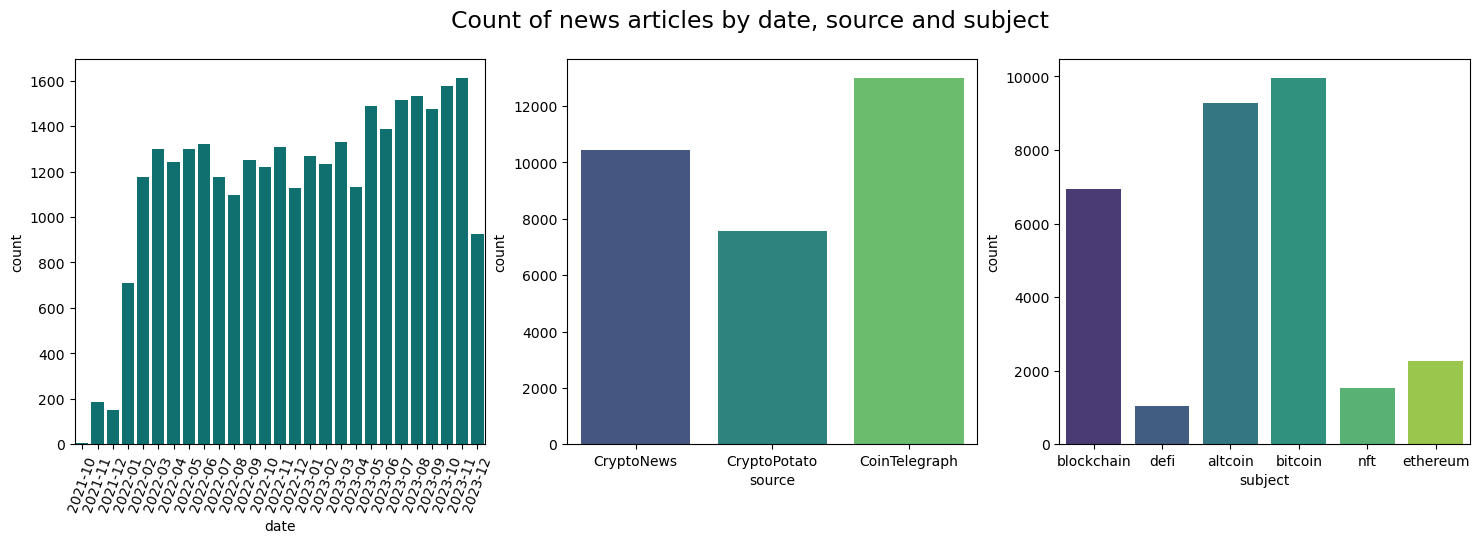

In [15]:
fig, sub = plt.subplots(1, 3, figsize = (18, 5))

sns.barplot(df['date'].value_counts().sort_index(), ax = sub[0], color = "teal")
sub[0].set_xticks(range(len(df['date'].value_counts().sort_index().index)))  
sub[0].set_xticklabels(df['date'].value_counts().sort_index().index, rotation=70)

sns.countplot(x="source", data=df, ax=sub[1], hue="source", legend=False, palette="viridis")

sns.countplot(x="subject", data=df, ax=sub[2], hue="subject", legend=False, palette="viridis")

fig.suptitle("Count of news articles by date, source and subject", fontsize = 17)
plt.show()

The countplots above show the distribution of news articles by date, source, and subject. Analyzing the date countplot, we see that the number of articles in 2021 was low (<200). During 2022 and 2023, it fluctuated around 1,200 articles per month, but in December 2023, it dropped to approximately 800. The source countplot indicates that most articles (over 12,000) came from CoinTelegraph, followed by CryptoNews with around 10,000, while CryptoPotato contributed the least, with fewer than 8,000. Regarding subjects, the most common topics were Bitcoin, altcoins (all cryptocurrencies except Bitcoin), and blockchain, while DeFi, NFT, and Ethereum were less frequent.

In [16]:
positive = df[df.sentiment == "positive"]
neutral = df[df.sentiment == "neutral"]
negative = df[df.sentiment == "negative"]

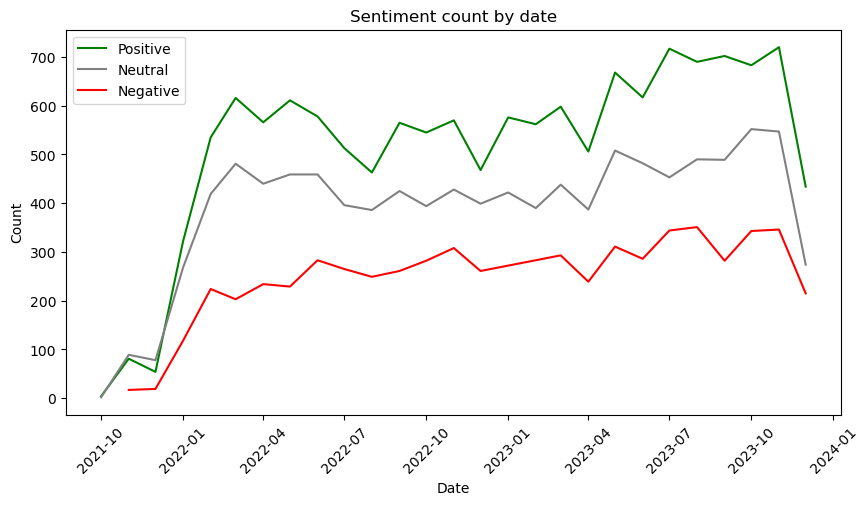

In [17]:
plt.figure(figsize = (10, 5))
sns.lineplot(x = pd.period_range('2021-10', '2023-12', freq='M').to_timestamp(), y = positive.groupby("date").count().sentiment, 
             color = "green", 
             label = "Positive")

sns.lineplot(x = pd.period_range('2021-10', '2023-12', freq='M').to_timestamp(), y = neutral.groupby("date").count().sentiment, 
             color = "grey", 
             label = "Neutral")

sns.lineplot(x = pd.period_range('2021-11', '2023-12', freq='M').to_timestamp(), y = negative.groupby("date").count().sentiment, 
             color = "red", 
             label = "Negative")

plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(loc = "upper left")
plt.xticks(rotation = 45)
plt.title("Sentiment count by date")
plt.show()

The chart above helps analyze sentiment distribution over time. Positive sentiment consistently had the highest number of articles, followed by neutral, with negative being the least frequent. The sentiment trends appear correlated, with spikes at the beginning of 2021 and declines in April 2023 and December 2023, affecting all sentiment categories and the total number of articles (from previous plot)

In [18]:
len(positive) / len(df) * 100, len(neutral) / len(df) * 100, len(negative) / len(df) * 100

(44.991461803653706, 34.00779714534266, 21.00074105100364)

The classes are slightly imbalanced, with 45% of articles having a positive sentiment, 34% neutral, and 21% negative.

### WordCloud of news articles

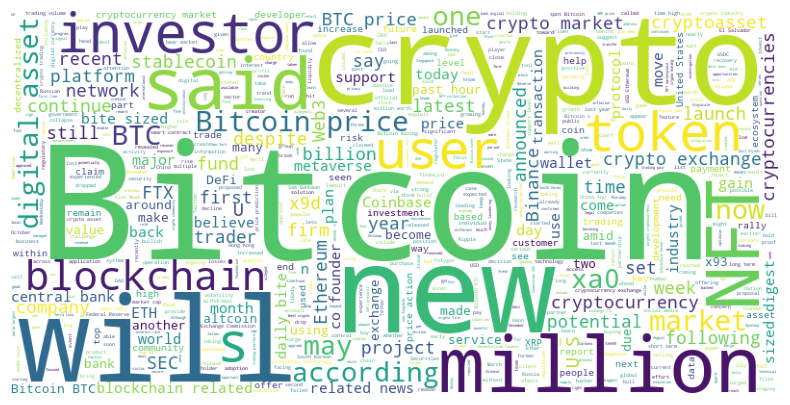

In [19]:
text_data = " ".join(df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=10000).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The word cloud shows that "Bitcoin," "new," "NFT," "crypto," "will," "said," and "million" are the most frequent words in the text of articles.

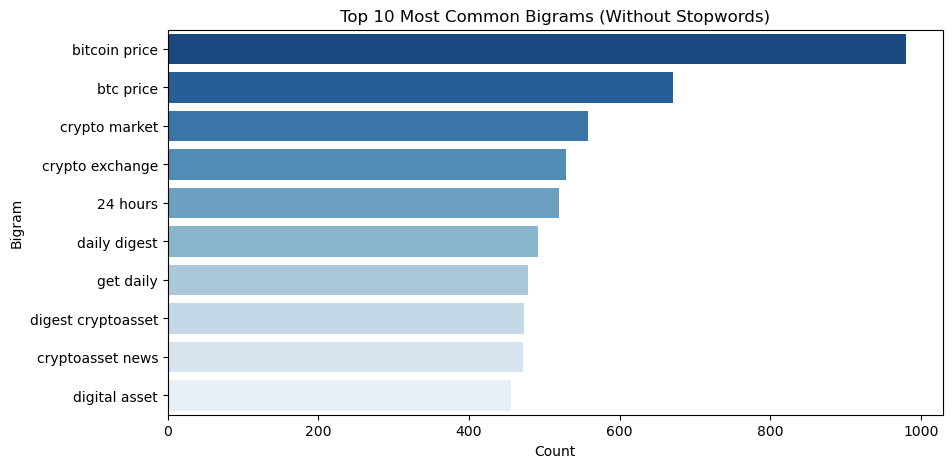

In [20]:
stop_words = set(stopwords.words("english"))

def get_bigrams(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    bigrams = list(nltk.bigrams(words))
    return [" ".join(bigram) for bigram in bigrams]

bigrams = []
for t in df["text"]:
    bigrams.extend(get_bigrams(t))

bigram_counts = Counter(bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Bigram", data=bigram_df, hue = "Bigram", palette="Blues_r")
plt.title("Top 10 Most Common Bigrams (Without Stopwords)")
plt.show()

Before extracting the most common bigrams, I removed stopwords (e.g., "in," "on," "the") from the text corpus. The most frequent bigrams are "bitcoin price" (1,000 occurrences), "btc price" (650), and "crypto market" (500).

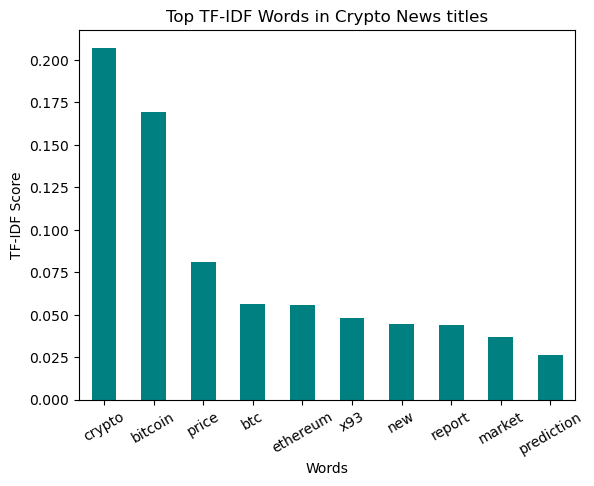

In [21]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix = vectorizer.fit_transform(df['title'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)

avg_tfidf.plot(kind='bar', color='teal')
plt.title("Top TF-IDF Words in Crypto News titles")
plt.xlabel("Words")
plt.ylabel("TF-IDF Score")
plt.xticks(rotation=30)
plt.show()

The top words in news titles identified using TF-IDF are "crypto," "bitcoin," and "price," indicating their high relevance in the dataset

## Data preparation

The models will be trained using the text feature, as it provides more relevant information than the title, the target variable will be sentiment.

In [22]:
X = df["text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

I split the dataset before preprocessing to prevent data leakage, using an 80/20 ratio.

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    text = text.strip()
    return text

X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

The text-cleaning function converts all text to lowercase, removes URLs, mentions, hashtags, punctuation, numbers, and extra spaces, then returns the cleaned text. I used this function to preprocess the text feature.

Besides cleaning, the text needs to be prepared for modeling using NLP preprocessing techniques. In this project, I applied only tokenization and TF-IDF vectorization without removing stopwords, stemming, or lemmatization.

In [24]:
def tfidf_vectorize(X_train, X_test, max_features=None):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

X_train, X_test = tfidf_vectorize(X_train, X_test)

I used TF-IDF vectorization because the dataset is not large, and I am training simple ML models. More complex models like Word2Vec or GloVe are unnecessary in this case.

In [25]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

Encoding the target variable with sentiments into numerical values using LabelEncoder.

## Classic ML models

The function to train all classic ML models has been created to avoid redundant code. I selected popular models like XGBoost, Random Forest, Logistic Regression and others. The evaluation metric will be accuracy, meaning the higher the accuracy, the better the model.

In [26]:
def classic_ml_models(X_train, y_train, X_test, y_test):
    models = [RandomForestClassifier(), XGBClassifier(), LogisticRegression(), MultinomialNB(), KNeighborsClassifier(), DecisionTreeClassifier(), LGBMClassifier(verbose = -1)]
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"{model.__class__.__name__} Accuracy: {round(accuracy_score(y_test, y_pred),2)}")

classic_ml_models(X_train, y_train, X_test, y_test)

RandomForestClassifier Accuracy: 0.85
XGBClassifier Accuracy: 0.88
LogisticRegression Accuracy: 0.87
MultinomialNB Accuracy: 0.55
KNeighborsClassifier Accuracy: 0.52
DecisionTreeClassifier Accuracy: 0.9
LGBMClassifier Accuracy: 0.91


Analyzing the accuracy of trained models, I conclude that the LightGBM model performed the best with an accuracy of 0.91. The Decision Tree model followed closely with 0.90 accuracy. In contrast, MultinomialNB and the KNN classifier performed the worst, with an accuracy around 0.53.

This is a good result for classic ML models, given the small dataset size. However, I will also try deep learning models like LSTM, GRU, and CNN for sentiment classification.

## Deep Learning models

For deep learning models, I will use the Keras tokenizer, allowing the embeddings to be learned directly from the dataset. I will clean the text using a custom function, split it into train/test sets, and encode the target variable as a numeric type.

In [58]:
X = df["text"]
X = X.apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [59]:
text_lengths = df["text"].apply(lambda x: len(x.split()))
print("Mean length:", np.mean(text_lengths))
print("95th percentile:", np.percentile(text_lengths, 95))

Mean length: 22.241647066404614
95th percentile: 35.0


The mean text length is 22 words, with the 95th percentile at 35 words. I will set the maximum length to 35, as it covers 95% of the data, ensuring all sentences are padded to the same length.

In [60]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_length = 35
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding="post")

For the Keras tokenizer, the `num_words` argument was set to 10,000 due to the small dataset. The out-of-vocabulary token was set as `<OOV>`. The tokenizer was fitted only on the X_train set to prevent data leakage, and both the train and test sets were subsequently padded.

## Simple NN

First, I will train a dense neural network with a single Dense layer containing 32 neurons and the ReLU activation function, followed by a softmax output layer. Early stopping will be applied to each model to prevent overfitting, as the dataset is small and neural networks tend to overfit after a few epochs. 

Additionally, I will use an Embedding layer with trainable parameters to learn word embeddings during model training. Despite the small size of the dataset, models tend to underfit when using pre-trained embeddings like Word2Vec or GloVe.

In [30]:
vocab_size = 10000
embedding_dim = 300
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(len(set(y)), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizers.Adam(), 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=32, callbacks=[early_stopping])

y_pred_nn = model.predict(X_test).argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_nn))

Epoch 1/10


2025-02-13 15:56:42.511737: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-13 15:56:42.511757: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-13 15:56:42.511766: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-13 15:56:42.511782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-13 15:56:42.511793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-13 15:56:42.761528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-02-13 15:56:42.764543: E t

776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6064 - loss: 0.8525 - val_accuracy: 0.8475 - val_loss: 0.4253
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9221 - loss: 0.2298 - val_accuracy: 0.8468 - val_loss: 0.4832
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9897 - loss: 0.0348 - val_accuracy: 0.8394 - val_loss: 0.6333
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8474548969072165


The model achieved an accuracy of 0.84, which is a decent result. However, previous models like LightGBM and Decision Tree performed better, suggesting that the dataset may be too small for deep learning models.

## LSTM model

Next, I will build an LSTM model with one layer and 32 neurons, followed by an output softmax layer. All hyperparameters will remain the same as in the previous model.

In [31]:
model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    layers.LSTM(32),
    layers.Dense(len(set(y)), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizers.Adam(), 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=32, callbacks=[early_stopping])
 
y_pred_nn = model.predict(X_test).argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_nn))

Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6382 - loss: 0.8009

2025-02-13 15:57:49.346919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


776/776 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.6383 - loss: 0.8006 - val_accuracy: 0.9075 - val_loss: 0.2967
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9236 - loss: 0.2481 - val_accuracy: 0.9336 - val_loss: 0.2229
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9607 - loss: 0.1398 - val_accuracy: 0.9343 - val_loss: 0.2361
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9743 - loss: 0.0950 - val_accuracy: 0.9233 - val_loss: 0.2694
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9336340206185567


The model achieved better performance than all previous models, with an accuracy of 0.93. It shows signs of overfitting after 2 epochs, so early stopping was triggered, halting training after the validation loss started to increase.

## GRU model

GRU is a simplified version of the LSTM layer with fewer parameters. I will use the same architecture as before, but with a GRU layer instead of an LSTM layer.

In [32]:
model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    layers.GRU(32),
    layers.Dense(len(set(y)), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizers.Adam(), 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=32, callbacks=[early_stopping])

y_pred_nn = model.predict(X_test).argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_nn))

Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5730 - loss: 0.8809

2025-02-13 15:59:00.839717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


776/776 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.5732 - loss: 0.8806 - val_accuracy: 0.9135 - val_loss: 0.2820
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9313 - loss: 0.2299 - val_accuracy: 0.9409 - val_loss: 0.2009
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9620 - loss: 0.1281 - val_accuracy: 0.9330 - val_loss: 0.2296
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9789 - loss: 0.0714 - val_accuracy: 0.9325 - val_loss: 0.2522
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9408827319587629


The GRU model achieved slightly better performance than the LSTM, with an accuracy of 0.94. Signs of overfitting are present again.

## CNN model

CNNs are also effective for sentiment classification because they can capture local patterns in text. Therefore, I will build a simple CNN model with one convolutional layer containing 32 neurons, a single filter, and a ReLU activation function, followed by a max pooling layer, a flatten layer, and an output layer. The hyperparameters remain the same as before.

In [61]:
model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    layers.Conv1D(32, 2, activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Flatten(),
    layers.Dense(len(set(y)), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizers.Adam(), 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=32, callbacks=[early_stopping])

y_pred_nn = model.predict(X_test).argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_nn))

Epoch 1/10


2025-02-13 17:21:55.081632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.7064 - loss: 0.6783 - val_accuracy: 0.9383 - val_loss: 0.2163
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9487 - loss: 0.1767 - val_accuracy: 0.9460 - val_loss: 0.1957
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9721 - loss: 0.0950 - val_accuracy: 0.9404 - val_loss: 0.2251
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9867 - loss: 0.0446 - val_accuracy: 0.9409 - val_loss: 0.2529
 83/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-02-13 17:23:01.057188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9460373711340206


The CNN model achieved an accuracy of 0.95, slightly better than the GRU. Training was stopped after 4 epochs, with the lowest loss observed in the second epoch.

## Model evaluation

In [41]:
y_pred_probs = model.predict(X_test, verbose=0)

print("ROC AUC Score:", round(roc_auc_score(y_test, y_pred_probs, multi_class="ovr"), 2))
print("F1-score:", round(f1_score(y_test, y_pred_nn, average="weighted"),2))

ROC AUC Score: 0.98
F1-score: 0.95


The best model (CNN) achieved an ROC AUC score of 0.98 and an F1-score of 0.95, which are great results.

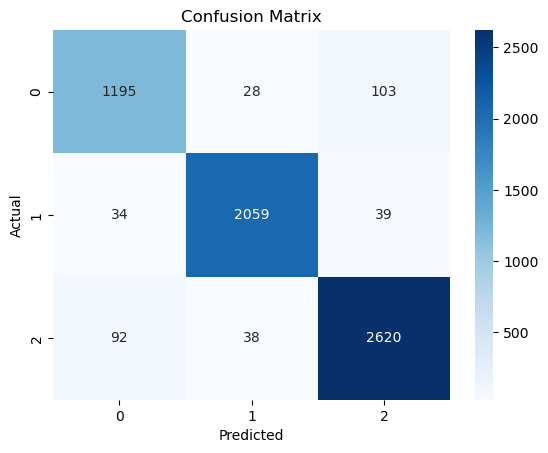

Encoded classes: ['negative' 'neutral' 'positive']


In [42]:
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Encoded classes:", le.classes_)

Classes were encoded as follows: negative (0), neutral (1), and positive (2). The confusion matrix shows that the model struggled the most with misclassifying negative news articles as positive (103 observations) and positive articles as negative (92 observations). Despite these misclassifications, the number of correctly classified observations is significantly higher.

## Example prediction

In [43]:
def example_prediction(text):
    text = clean_text(text)
    tokenized = tokenizer.texts_to_sequences([text])
    padded = keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=max_length, padding="post")
    prediction = model.predict(padded, verbose=0).argmax(axis=1)
    return le.inverse_transform(prediction).item()

example = "Bitcoin falls below $40,000 as Europe declares all crypto transactions illegal."

print("Example text:", example)
print("Predicted sentiment:", example_prediction(example))

Example text: Bitcoin falls below $40,000 as Europe declares all crypto transactions illegal.
Predicted sentiment: negative


In [44]:
example = "Tesla buys $1.5 billion worth of Bitcoin."

print("Example text:", example)
print("Predicted sentiment:", example_prediction(example))

Example text: Tesla buys $1.5 billion worth of Bitcoin.
Predicted sentiment: positive


In [64]:
model.save("app/model.keras")

export_data = {'clean_text': inspect.getsource(clean_text), 
           'tokenizer': tokenizer,
           'label_encoder': le,
           'max_len': max_length}

with open('app/encoding_vars.pkl', 'wb') as f:
    pickle.dump(export_data, f)

## Conclusion

The project demonstrates how NLP techniques can be applied to analyze cryptocurrency market sentiment by processing and extracting insights from news articles. By leveraging both classic machine learning models and deep learning architectures for sentiment classification, the project provides sentiment-based insights that can support traders and investors in optimizing their decision-making strategies.

## Thanks for reading!